In [163]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class Financial_Timeseries(yf.Ticker):
    valid_periods = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

    def __init__(self, ticker, period='max'):
        super().__init__(ticker)

        if isinstance(period, dict) and not {'start', 'end'} == period.keys():
            print('Period should be a dict(start="2000-01-01",end="2002-01-01"')
            print('Period should have start and end dates in %Y-%m-%d format')
            raise TypeError

        elif isinstance(period, str) and period not in self.valid_periods:
            print('Period should be a valid time period:')
            print(valid_periods)
            raise TypeError

        elif isinstance(period, dict):
            try:
                self.timeseries = self.ticker.history(**period)
            except ValueError:
                print('Period should be in %Y-%m-%d format')
                raise ValueError

        elif isinstance(period, str):
            self.timeseries = self.history(period=period)


    def plot_timeseries(self,series=None,fig_size=(10,10)):

        fig, axs = plt.subplots(4,1, figsize=fig_size, squeeze=True)
        fig.suptitle('{} Timeseries of {}'.format(series, self.info['name'] if 'name' in self.info else self.ticker))

        series = self.timeseries[['Open','High','Low','Close']] if series is None else self.timeseries[series]
        returns = series.pct_change()

        sns.lineplot(data=series, ax=axs[0])
        sns.lineplot(data=returns, ax=axs[1])
        sns.lineplot(data=np.log(1 + returns),ax=axs[2])
        axs[3].bar(x=self.timeseries.index, height=self.timeseries['Volume'])

        axs[0].title.set_text('Values')
        axs[0].tick_params(labelrotation=45)

        axs[1].title.set_text('Returns')
        axs[1].tick_params(labelrotation=45)

        axs[2].title.set_text('Log Returns')
        axs[2].tick_params(labelrotation=45)

        axs[3].title.set_text('Daily Volume')
        axs[3].tick_params(labelrotation=45)

        fig.tight_layout()


    def plot_ACF_PACF(self, series='Close', transformation='values'):

        fig, axs = plt.subplots(2,2, figsize=(10, 5), squeeze=True)
        fig.suptitle('{} AutoCorrelation Plots of the {}'.format(series,transformation))

        if transformation == 'values':
            series = self.timeseries[series]

        elif transformation == 'log returns':
            series = np.log(1+self.timeseries[series].pct_change()).dropna()

        elif transformation == 'returns':
            series = self.timeseries[series].pct_change().dropna()

        else:
            print('Can only plot the values, returns, or log returns')
            raise ValueError

        plot_acf(series, ax=axs[0,0], zero=False)
        plot_pacf(series, ax=axs[0,1], zero=False)
        plot_acf(series**2, ax=axs[1,0], zero=False)
        plot_acf(abs(series), ax=axs[1,1], zero=False)

        axs[0,0].title.set_text('ACF')
        axs[0,0].tick_params(labelrotation=45)

        axs[0,1].title.set_text('PACF')
        axs[0,1].tick_params(labelrotation=45)

        axs[1,0].title.set_text('ACF squared')
        axs[1,0].tick_params(labelrotation=45)

        axs[1,1].title.set_text('ACF Absolute value')
        axs[1,1].tick_params(labelrotation=45)

        fig.tight_layout()



In [164]:
data = Financial_Timeseries('BTC-USD', period='max')

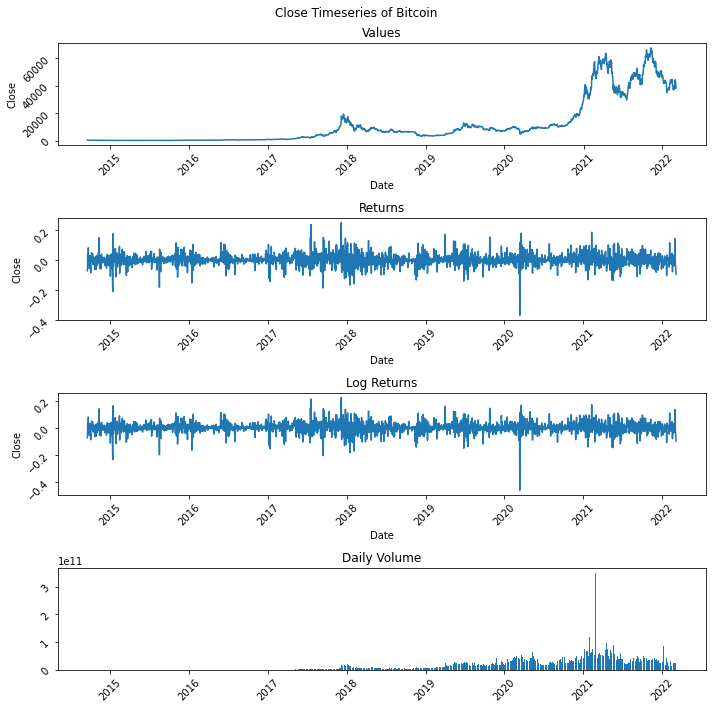

In [165]:
data.plot_timeseries('Close')

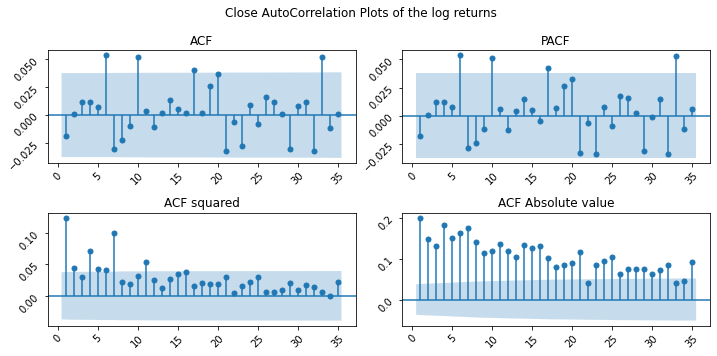

In [166]:
data.plot_ACF_PACF('Close',transformation='log returns')

In [157]:
import pmdarima as arima
from arch import arch_model
log_returns = np.log(1+data.timeseries['Close'].pct_change()).dropna()
arima_model_fitted = arima.auto_arima(log_returns)

arima_residuals = arima_model_fitted.arima_res_.resid

model = arch_model(arima_residuals, vol='GARCH', p=1, q=1, rescale=True, mean='Zero')
fitted_model = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12117.99178396262
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1637.203772864545
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1432.9786729133104
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1120.536368537179
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1101.98524474085
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1097.9524553873075
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1097.689864852352
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1097.6898446135665
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1097.689844613053
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1097.6898446135665
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9


In [158]:
print(fitted_model.scale)

10.0


In [159]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1097.69
Distribution:                  Normal   AIC:                           2201.38
Method:            Maximum Likelihood   BIC:                           2219.11
                                        No. Observations:                 2725
Date:                Sun, Mar 06 2022   Df Residuals:                     2725
Time:                        17:54:28   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.8895e-03  2.515e-03      2.739  6.160e-03 [1.960e-03,1.182e-02]
alpha[1]       0.1254  3.557e-02      3.525  4.240e-04   [5.566e-02,  0.195]
beta[1]        0.8431  2.837e-02     29.713 5.256e-194     [  0.787,  0.899]
============================================================================

Covariance estimator: robust
"""

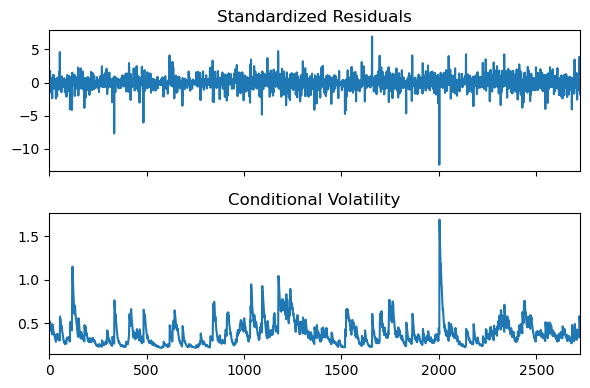

In [160]:
results = fitted_model.plot()
results.tight_layout()
results.set_dpi(100)

In [161]:
forecast = fitted_model.forecast(reindex=False)
print(np.sqrt(forecast.residual_variance))

           h.1
2724  0.549848


In [162]:
from Bitcoin_MonteCarlo import forecast_sigma

forecast_sigma(fitted_model.params, np.log(1+data.timeseries['Close'].pct_change())[-1],np.log(1+data.timeseries['Close'].pct_change()).std())

0.09528418379934024